# Sentiment Analysis of IMDB Movie Reviews

In [1]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

## Data Collection 

In [2]:
#Importing the Dataset
movies=pd.read_csv('IMDB Dataset.csv')
movies.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
print(movies.shape)
print('========================================================================')
print(movies.dtypes)
print('========================================================================')
print(movies.describe())

(50000, 2)
review       object
sentiment    object
dtype: object
                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000


## Exploratory Data Analysis

<Axes: xlabel='sentiment', ylabel='count'>

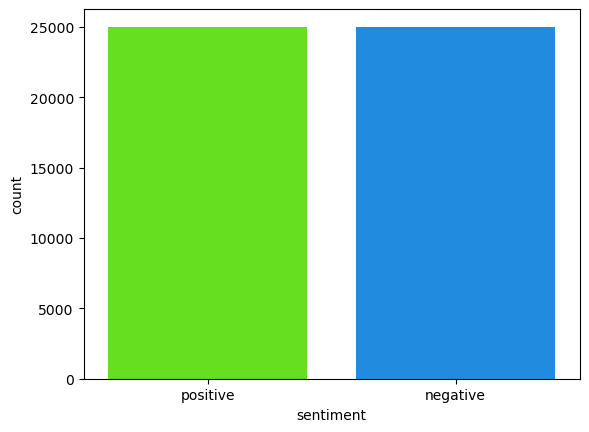

In [4]:
sns.countplot(data=movies,x=movies['sentiment'],palette='gist_rainbow')

In [5]:
# Making datasets to visualise
movies["len"] = np.array([len(i) for i in movies['review']])

neg = movies.where(movies["sentiment"]=='negative').dropna().reset_index().drop(["index"],axis=1)
pos = movies.where(movies["sentiment"]=='positive').dropna().reset_index().drop(["index"],axis=1)

In [6]:
def len_hist(data):
    plt.figure(figsize=(25,5))
    sns.histplot(data["len"],bins=100)
    plt.title("Total Reviews")
    plt.show()
    plt.clf()

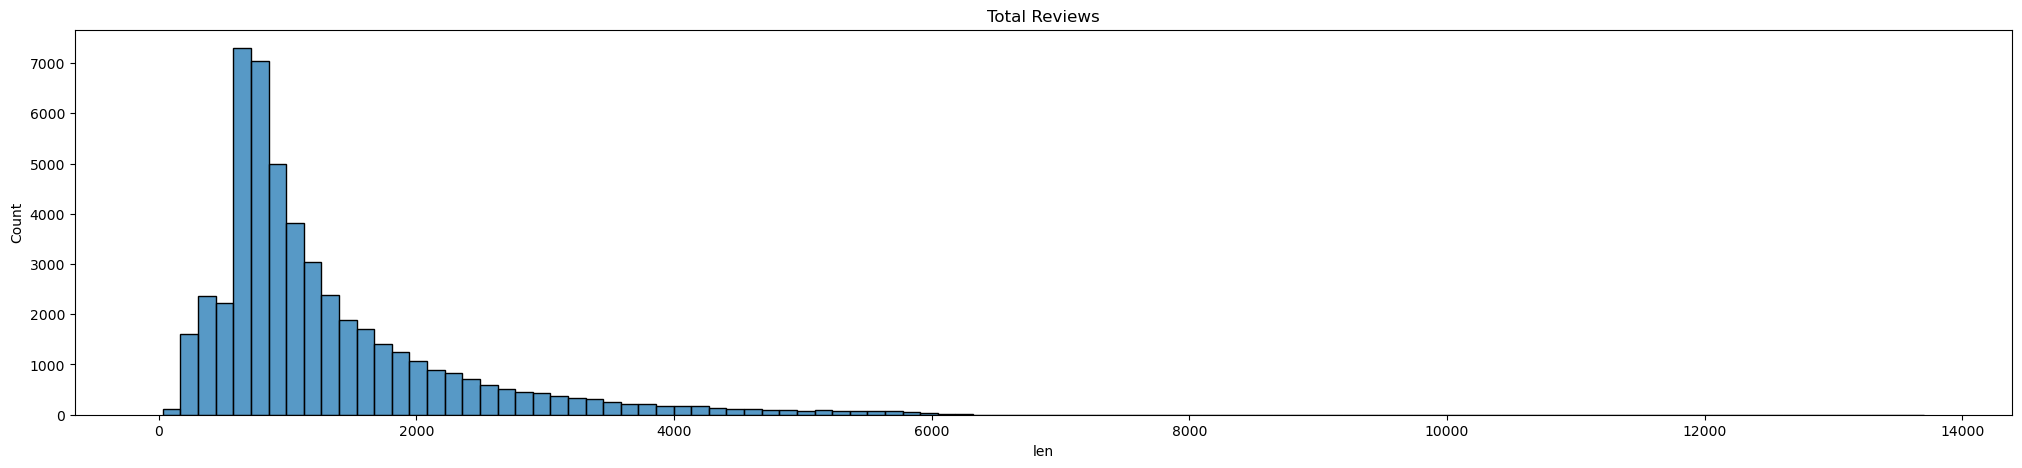

Histogram of Negative Reviews:


<Figure size 640x480 with 0 Axes>

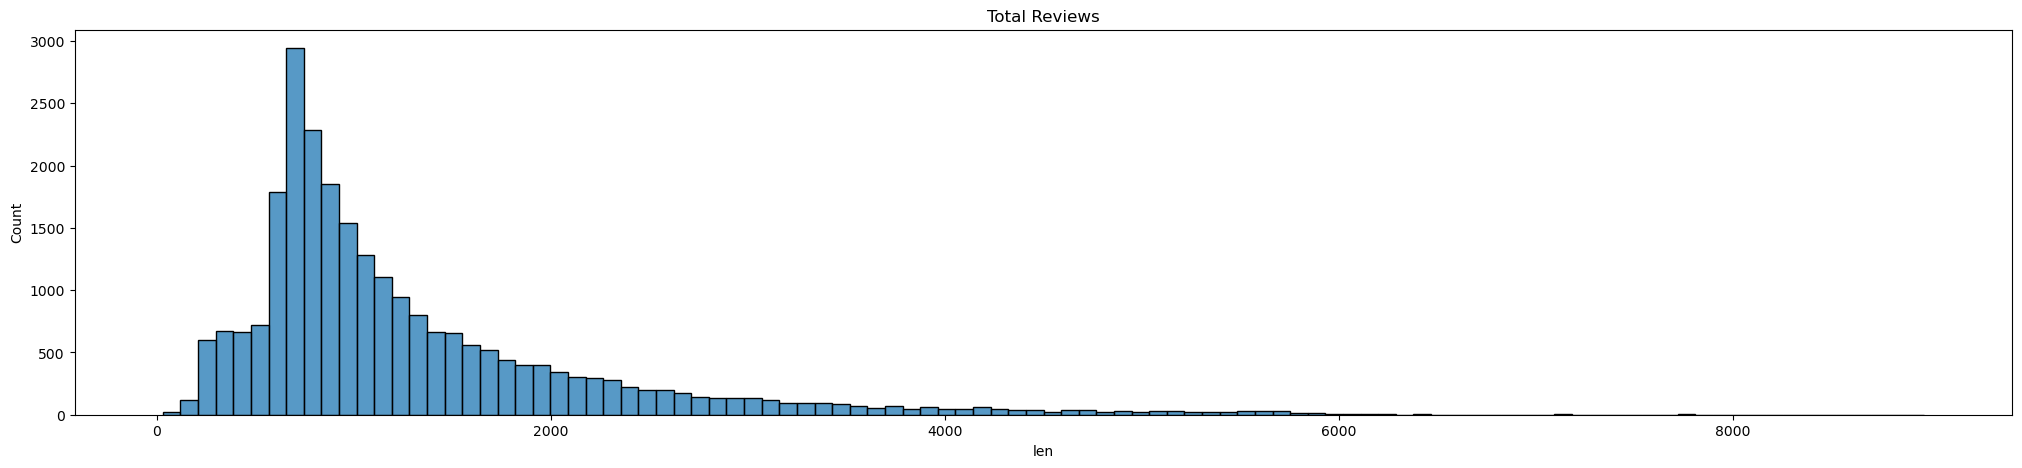

Histogram of Positive Reviews:


<Figure size 640x480 with 0 Axes>

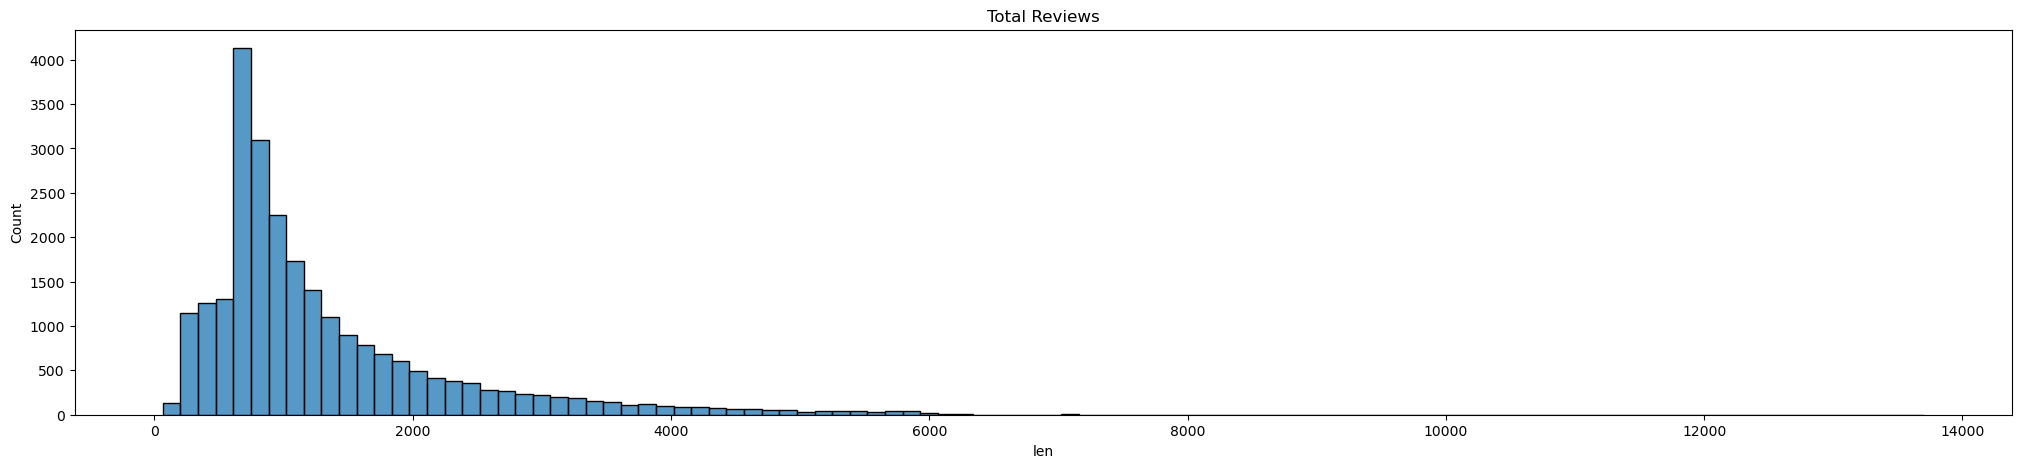

<Figure size 640x480 with 0 Axes>

In [7]:
len_hist(movies)
print('Histogram of Negative Reviews:')
len_hist(neg)
print('Histogram of Positive Reviews:')
len_hist(pos)

In [8]:
norm_reviews=movies.review[:40000]
norm_reviews[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

<function matplotlib.pyplot.show(close=None, block=None)>

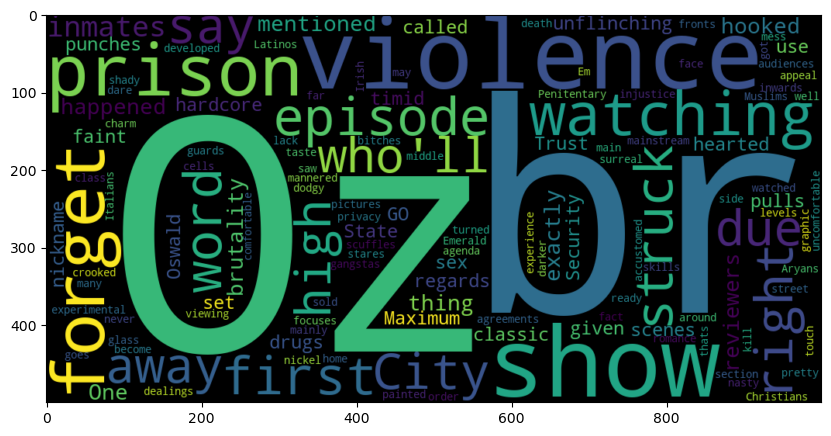

In [9]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=norm_reviews[0]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

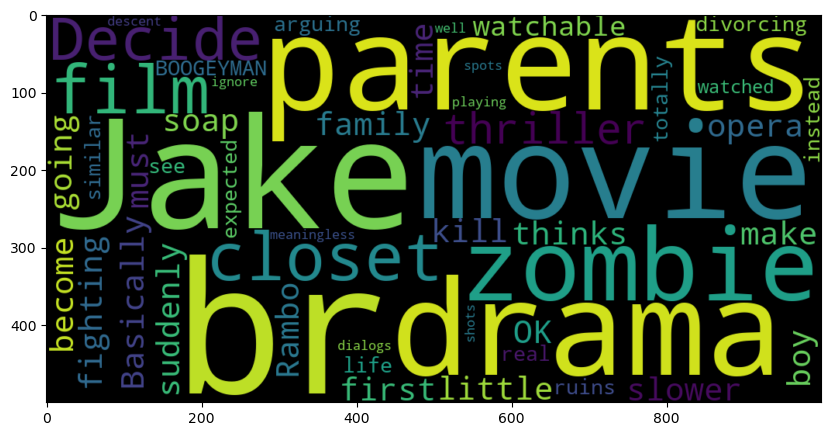

In [10]:
#Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=norm_reviews[3]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

___Exploratory Data Analysis can also be done at each level by plotting most common words in the text.___

## Data Preprocessing

In [11]:
#Sampling 10000 rows randomly for smooth processing
sample = movies.sample(10000, ignore_index=True)
sample.head()

,review,sentiment,len
0,This film is full of charming situations and h...,positive,792
1,OK I for one thought the trailer was quite goo...,negative,1145
2,"In the autobiographical coming-of-age tale ""Ro...",negative,1340
3,Telling the story wouldn't be the point at all...,positive,3411
4,"Well, the artyfartyrati of Cannes may have lik...",negative,904


In [12]:
sample['sentiment'].value_counts()

negative    5050
positive    4950
Name: sentiment, dtype: int64

In [13]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10000 non-null  object
 1   sentiment  10000 non-null  object
 2   len        10000 non-null  int32 
dtypes: int32(1), object(2)
memory usage: 195.4+ KB


In [14]:
sample['sentiment'].replace({'positive':1,'negative':0},inplace=True)

In [15]:
sample.head(10)

,review,sentiment,len
0,This film is full of charming situations and h...,1,792
1,OK I for one thought the trailer was quite goo...,0,1145
2,"In the autobiographical coming-of-age tale ""Ro...",0,1340
3,Telling the story wouldn't be the point at all...,1,3411
4,"Well, the artyfartyrati of Cannes may have lik...",0,904
5,"An overlong, but compelling retelling of the f...",1,634
6,The whole does not even come close to the sum ...,1,651
7,This film is just a kids against evil genre. T...,0,636
8,Angela (Sandra Bullock) is a computer expert b...,1,1676
9,I loved this movie! I'm shocked and disappoint...,1,304


0    5050
1    4950
Name: sentiment, dtype: int64


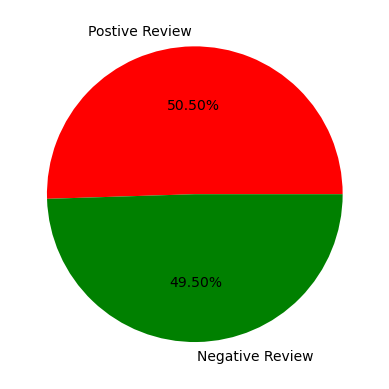

In [16]:
#Checking the class balance of the dataset
print(sample['sentiment'].value_counts())
plt.pie(labels=['Postive Review', 'Negative Review'], 
        x = sample['sentiment'].value_counts().values,
        autopct='%.2f%%',
        colors = ['red', 'green'])
plt.show()

In [17]:
clean_text = re.compile('<.*?>')
re.sub(clean_text,'',sample.iloc[1].review)

"OK I for one thought the trailer was quite good so was hopeful for this film, plus with the cast line up I was sure it couldn't get less than a 6 in my books. However I got annoyed half hour into the story... just where normal films get good, this film hit rock bottom. SPOILER * The guy who everyone is trying to help is so caring of other people getting hurt in the middle of the hustle that he turns on his colleagues to save a tramp and then locks himself inside one of the armoured trucks. Not only that, he constantly tries to get other peoples attention by which he ends up endangering more people and long story short, the outcome is that he is responsible for not just the tramps death, but also a police officer getting shot and the kidnapping of his younger brother... oh and all 5 of his colleagues dying disgraced deaths. But in the end he is HAPPY because he came to his senses halfway through the endeavour, so what if all his colleagues are now dead rather than sticking to the plan 

In [18]:
#Clearinh html tags
def Clean_html(text):
    clean = re.compile('<.*?>')
    return re.sub(clean,'',text)

#Converting text to lower case
def Convert_Lower(text):
    return text.lower()

#Removing Special Characters
def Remove_Special(text):
    x=''
    for i in text:
        if i.isalnum():
            x=x+i
        else:
            x=x+' '
    return x

#Removing Stop Words
def Remove_Stopwords(text):
    x=[]
    for i in text.split():
        if i not in stopwords.words('english'):
            x.append(i)
    y=x[:]
    x.clear()
    return y

y=[]
def Stem_Words(text):
    for i in text:
        y.append(PorterStemmer().stem(i))
    z=y[:]
    y.clear()
    return z

def Join_Back(list_input):
    return " ".join(list_input)

In [19]:
#Applying the functions on the Dataset
sample['review'] = sample['review'].apply(Clean_html)
sample['review'] = sample['review'].apply(Convert_Lower)
sample['review'] = sample['review'].apply(Remove_Special)
sample['review'] = sample['review'].apply(Remove_Stopwords)
sample['review'] = sample['review'].apply(Stem_Words)
sample['review'] = sample['review'].apply(Join_Back)

___Feature Engineering can be improved by normalizing the data before modeling___

## Modeling

In [20]:
#Using countvectoriser for creating bag of words
X = CountVectorizer().fit_transform(sample['review']).toarray()

In [21]:
print(X.shape)
y=sample.iloc[:,-1].values
print(y.shape)

(10000, 36038)
(10000,)


In [22]:
#Creating train and test dataset
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [23]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 36038)
(2000, 36038)
(8000,)
(2000,)


In [24]:
#Defining Classifiers
Clf1=GaussianNB()
Clf2=MultinomialNB()
Clf3=BernoulliNB()
Rfcc=RandomForestClassifier()

In [ ]:
Clf1.fit(X_train,y_train)
Clf2.fit(X_train,y_train)
Clf3.fit(X_train,y_train)
Rfcc.fit(X_train,y_train)

In [55]:
y_pred_GNB=Clf1.predict(X_test)
y_pred_MNB=Clf2.predict(X_test)
y_pred_BNB=Clf3.predict(X_test)
y_pred_Rfcc=Rfcc.predict(X_test)

## Evaluation

In [56]:
print("Gaussian",accuracy_score(y_test,y_pred_GNB))
print("Multinomial",accuracy_score(y_test,y_pred_MNB))
print("Bernoulli",accuracy_score(y_test,y_pred_BNB))
print("RandomForestClassifier",accuracy_score(y_test,y_pred_Rfcc))

Gaussian 0.645
Multinomial 0.834
Bernoulli 0.8375
RandomForestClassifier 0.8295


___BernoulliNB performed better with highest accuracy of 83.75%___

In [82]:
cm1 = confusion_matrix(y_pred_BNB, y_test)
report1 = classification_report(y_pred_BNB, y_test)
print(f'Confusion Matrix: \n{cm1}')
print(f'Classification Report: \n{report1}')

Confusion Matrix: 
[[891 186]
 [139 784]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1077
           1       0.81      0.85      0.83       923

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



In [83]:
cm2 = confusion_matrix(y_pred_GNB, y_test)
report2 = classification_report(y_pred_GNB, y_test)
print(f'Confusion Matrix: \n{cm2}')
print(f'Classification Report: \n{report2}')

Confusion Matrix: 
[[749 429]
 [281 541]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.73      0.64      0.68      1178
           1       0.56      0.66      0.60       822

    accuracy                           0.65      2000
   macro avg       0.64      0.65      0.64      2000
weighted avg       0.66      0.65      0.65      2000



In [84]:
cm3 = confusion_matrix(y_pred_MNB, y_test)
report3 = classification_report(y_pred_MNB, y_test)
print(f'Confusion Matrix: \n{cm3}')
print(f'Classification Report: \n{report3}')

Confusion Matrix: 
[[892 194]
 [138 776]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1086
           1       0.80      0.85      0.82       914

    accuracy                           0.83      2000
   macro avg       0.83      0.84      0.83      2000
weighted avg       0.84      0.83      0.83      2000



In [85]:
cm4 = confusion_matrix(y_pred_Rfcc, y_test)
report4 = classification_report(y_pred_Rfcc, y_test)
print(f'Confusion Matrix: \n{cm4}')
print(f'Classification Report: \n{report4}')

Confusion Matrix: 
[[870 181]
 [160 789]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1051
           1       0.81      0.83      0.82       949

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000

